In [5]:
# importing required libraries
#!pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage import color

import sklearn
import keras
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def rescale(i, image, width, height):
  new_im = cv2.resize(image,(width,height))
  # normalize values to be between -1 and 1
  # new_im = (new_im - 127.5 )/127.5
  # normalize values to be between 0 and 1
  new_im = new_im/255
  return new_im

In [3]:
# We first load the necessary libraries, the dataset and reshape its dimensons

# FOR INITIAL RAW IMAGES
faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/def_front/'
ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/ok_front/'

# FOR AUGMENTED IMAGES
#faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/'
#ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/'
directories = (faulty_dir, ok_dir)

# check the total number of images we have
count = 0
for direct in directories:
  for file in os.listdir(direct):
    count += 1

# set the values of the X and y arrays
num_images = count
input_shape = (100, 100, 3)
height = input_shape[0]
width = input_shape[1]
channels = input_shape[2]

X = np.zeros((num_images,height,width,channels))
y = np.zeros((num_images))

# populate the arrays
i = 0
j = -1
for direct in directories:
  j+=1
  for file in os.listdir(direct):
    path = (direct+file)
    im = plt.imread(path)
    scaled_im = rescale(i, im, width, height)
    X[i,:,:,:] = scaled_im
    if j == 0:
      # 1 for faulty
      y[i] = 1
    else:
      # 0 for ok image
      y[i] = 0
    i+=1

# one-hot encoding using function from Keras
# y = to_categorical(y)

In [27]:
# use Keras function to split the arrays into training, test, and validation (70%, 15%, 15%)
# y = to_categorical(y)
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state=1)

print(X_train.shape, X_valid.shape, X_test.shape)
print(np.min(X_train), np.max(X_train))
print(np.min(X_valid), np.max(X_valid))
print(type(X_train),type(y_train))

(910, 100, 100, 3) (195, 100, 100, 3) (195, 100, 100, 3)
0.0 1.0
0.00392156862745098 1.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
print(y_train.shape, y_valid.shape)

(910,) (195,)


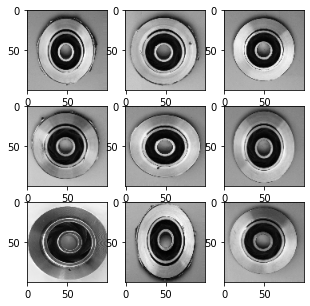

In [8]:
f, axarr = plt.subplots(3,3,figsize=(5,5))
for i in range(9):
  row = int(i/3)
  col = int(i%3)
  axarr[row,col].imshow(X[i,:,:,0], cmap='gray')
plt.show()

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same', input_shape=(100, 100, 3)),
    #tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    #tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D(256, (3,3), activation=tf.keras.layers.LeakyReLU(0.05), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    # bias_regularizer=regularizers.l2(1e-4), padding = 'same'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [30]:
def custom_loss(y_true, y_pred):       
    loss = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    FN = K.mean(K.greater(y_true, y_pred)) #Total False Negatives / Total Batch Size
    loss = loss + 2*FN
    return loss
  
loss_binary = tf.keras.losses.BinaryCrossentropy()
loss_class = tf.keras.losses.CategoricalCrossentropy()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_24 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                      

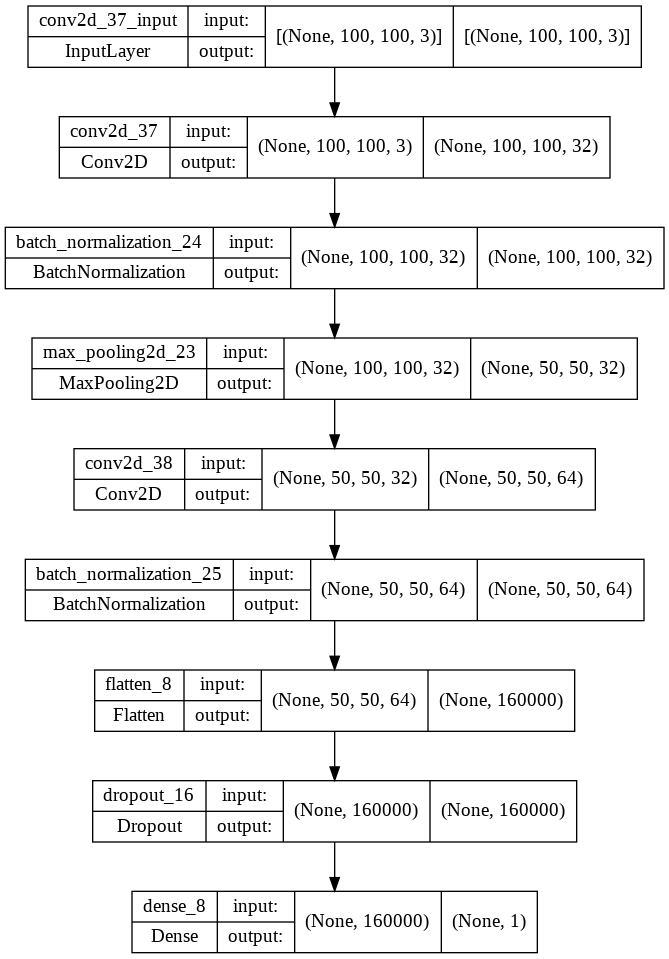

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss_binary, metrics=['accuracy','Precision', 'Recall', 'AUC'])
model.summary()
tf.keras.utils.plot_model(model, "CustomCNN.png", show_shapes=True)

In [37]:
config = 1
transform = ""
preprocess = "Binary"
path_name = f"{'/content/drive/Shareddrives/Senior Thesis/my_model_'}{config}{'_'}{preprocess}{'_'}{transform}{'.hdf5'}"
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(path_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
BATCHSIZE = 128

model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_valid,y_valid), shuffle=True)

Epoch 1/10
8/8 [==============================] - 9s 941ms/step - loss: 1.0326 - accuracy: 0.6967 - precision: 0.7490 - recall: 0.7295 - auc: 0.7360 - val_loss: 0.8080 - val_accuracy: 0.3487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8141 - lr: 1.0000e-04
Epoch 2/10
8/8 [==============================] - 6s 762ms/step - loss: 0.6087 - accuracy: 0.7308 - precision: 0.7670 - recall: 0.7799 - auc: 0.8130 - val_loss: 0.8299 - val_accuracy: 0.3487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8551 - lr: 1.0000e-04
Epoch 3/10
8/8 [==============================] - 6s 765ms/step - loss: 0.4587 - accuracy: 0.8187 - precision: 0.8330 - recall: 0.8657 - auc: 0.8950 - val_loss: 0.8224 - val_accuracy: 0.3487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8421 - lr: 1.0000e-04
Epoch 4/10
8/8 [==============================] - 7s 849ms/step - loss: 0.3698 - accuracy: 0.8407 - precision: 0.8587 - recall: 0.8731 - auc: 0.9194 - val_loss: 0.

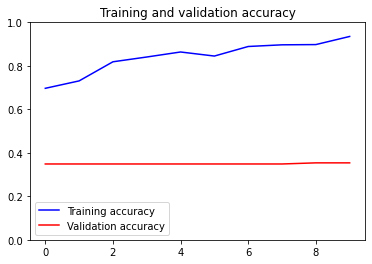

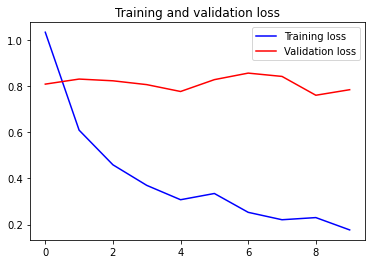

In [38]:
# plot training and validation losses and accuracy versus number of epochs
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(0,1.0)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
from keras.models import load_model
model = load_model(path_name)

In [40]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 37ms/step - loss: 0.7451 - accuracy: 0.3949 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8455


[0.7451422810554504, 0.3948718011379242, 0.0, 0.0, 0.8454765677452087]